In [1]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers, losses
#from tensorflow.Keras import losses
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#import pydot



In [2]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()

In [3]:
data= pd.read_csv("IMDB_Dataset.csv")

In [4]:
train_data = data[:40000]
test_data = data[40000:]

In [5]:
test_data

,review,sentiment
40000,First off I want to say that I lean liberal on...,negative
40001,I was excited to see a sitcom that would hopef...,negative
40002,When you look at the cover and read stuff abou...,negative
40003,"Like many others, I counted on the appearance ...",negative
40004,"This movie was on t.v the other day, and I did...",negative
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [6]:
train_data= train_data
train_data.dropna(axis = 0, how ='any',inplace=True) 
train_data['Num_words_review'] = train_data['review'].apply(lambda x:len(str(x).split())) 
mask = train_data['Num_words_review'] >2
train_data = train_data[mask]
print('-------Train data--------')
print(train_data['sentiment'].value_counts())
print(len(train_data))
print('-------------------------')
max_train_sentence_length  = train_data['Num_words_review'].max()

train_data['review'] = train_data['review'].apply(clean_text)


test_data= test_data
test_data.dropna(axis = 0, how ='any',inplace=True) 
test_data['Num_words_review'] = test_data['review'].apply(lambda x:len(str(x).split())) 

max_test_sentence_length  = test_data['Num_words_review'].max()

mask = test_data['Num_words_review'] >2
test_data = test_data[mask]

print('-------Test data--------')
print(test_data['sentiment'].value_counts())
print(len(test_data))
print('-------------------------')

test_data['review'] = test_data['review'].apply(clean_text)


print('Train Max Sentence Length :'+str(max_train_sentence_length))
print('Test Max Sentence Length :'+str(max_test_sentence_length))

-------Train data--------
negative    20007
positive    19993
Name: sentiment, dtype: int64
40000
-------------------------
-------Test data--------
positive    5007
negative    4993
Name: sentiment, dtype: int64
10000
-------------------------
Train Max Sentence Length :2470
Test Max Sentence Length :2278


In [7]:
num_words = 20000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['review'].tolist()) 

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['review'].tolist(),\
                                                      train_data['sentiment'].tolist(),\
                                                      test_size=0.1,\
                                                      stratify = train_data['sentiment'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))


x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['review'].tolist()) )



x_train = pad_sequences(x_train, padding='post', maxlen=2500)
x_valid = pad_sequences(x_valid, padding='post', maxlen=2500)
x_test = pad_sequences(x_test, padding='post', maxlen=2500)

print(x_train[0])

le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
#print(train_labels)
valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(test_data['sentiment'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

Train data len:36000
Class distributionCounter({&#39;negative&#39;: 18006, &#39;positive&#39;: 17994})
Valid data len:4000
Class distributionCounter({&#39;negative&#39;: 2001, &#39;positive&#39;: 1999})
[ 178 1590 4153 ...    0    0    0]


In [10]:
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))


[&#39;positive&#39;, &#39;positive&#39;, &#39;positive&#39;, &#39;positive&#39;, &#39;negative&#39;, &#39;positive&#39;, &#39;positive&#39;, &#39;positive&#39;, &#39;negative&#39;, &#39;negative&#39;]
Text to number
[1 1 1 1 0 1 1 1 0 0]


In [11]:
## building model


max_features =20000
embedding_dim =64
sequence_length = 2500

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))                                    

model.add(tf.keras.layers.Conv1D(100, 3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))                               


model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(2, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
                               



model.summary()


Model: &quot;sequential&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2500, 64)          1280064   
_________________________________________________________________
conv1d (Conv1D)              (None, 2498, 100)         19300     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 1,299,566
Trainable params: 1,299,566
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
                optimizer='Nadam', 
                metrics=["CategoricalAccuracy"])

In [13]:
#Train model with epoch 5 as otherwise it will take very long
epochs = 5
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(2000).batch(128),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(128),
                    verbose=1)

Epoch 1/5
282/282 [==============================] - 314s 1s/step - loss: 0.6595 - categorical_accuracy: 0.7149 - val_loss: 0.5551 - val_categorical_accuracy: 0.7905
Epoch 2/5
282/282 [==============================] - 302s 1s/step - loss: 0.5657 - categorical_accuracy: 0.7853 - val_loss: 0.5483 - val_categorical_accuracy: 0.8077
Epoch 3/5
282/282 [==============================] - 288s 1s/step - loss: 0.5602 - categorical_accuracy: 0.7973 - val_loss: 0.5469 - val_categorical_accuracy: 0.8123
Epoch 4/5
282/282 [==============================] - 292s 1s/step - loss: 0.5586 - categorical_accuracy: 0.7999 - val_loss: 0.5462 - val_categorical_accuracy: 0.8158
Epoch 5/5
282/282 [==============================] - 302s 1s/step - loss: 0.5573 - categorical_accuracy: 0.8049 - val_loss: 0.5457 - val_categorical_accuracy: 0.8163


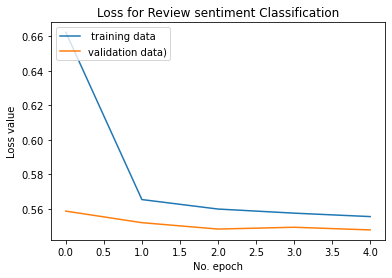

In [13]:
#plot the learning process

plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Review sentiment Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [15]:
history_dict = history.history
print(history_dict.keys())


dict_keys([&#39;loss&#39;, &#39;categorical_accuracy&#39;, &#39;val_loss&#39;, &#39;val_categorical_accuracy&#39;])


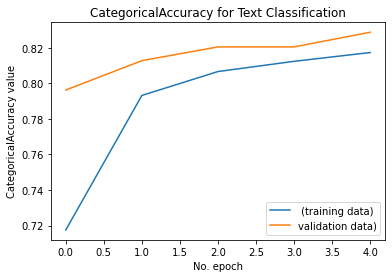

In [19]:
plt.plot(history.history['categorical_accuracy'], label=' (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='validation data)')
plt.title('CategoricalAccuracy for Text Classification')
plt.ylabel('CategoricalAccuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()


In [23]:
# testing model.

x_test  = np.array( tokenizer.texts_to_sequences(test_data['review'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=2500)

In [24]:
predictions = model.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)

[[0.99765617 0.00234291]
 [0.6987173  0.30188772]
 [0.16261691 0.8379898 ]
 ...
 [0.9241817  0.07675385]
 [0.31709868 0.6824435 ]
 [0.96519625 0.03552228]]


In [25]:
test_data['pred_sentiment']= predict_results
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == 0),'negative',test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '1'),'positive',test_data.pred_sentiment)

In [26]:
test_data

,review,sentiment,Num_words_review,pred_sentiment
40000,first off want say that lean liberal the polit...,negative,166,negative
40001,was excited see sitcom that would hopefully re...,negative,206,negative
40002,when you look the cover and read stuff about e...,negative,221,positive
40003,like many others counted the appearance dennis...,negative,323,negative
40004,this movie was the other day and didnt enjoy a...,negative,151,negative
...,...,...,...,...
49995,thought this movie did down right good job was...,positive,194,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative,112,negative
49997,catholic taught parochial elementary schools n...,negative,230,negative
49998,going have disagree with the previous comment ...,negative,212,positive


In [27]:
labels = ['positive', 'negative']
    
print(classification_report(test_data['sentiment'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

    positive       0.80      0.84      0.82      5007
    negative       0.83      0.79      0.81      4993

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



In [ ]:
#What is f1 score - It is the harmonic mean of precision and recall. Output range is [0, 1]. Works for both multi-class and multi-label classification.


#Conclusion: even with the small amount of epochs, the model predicts very well (0.82 f1 score)